In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import random
from scipy.sparse import csr_matrix

from tqdm import tqdm
from collections import defaultdict

from joblib import Parallel, delayed


from implicit.als import AlternatingLeastSquares

from catboost import *
from catboost import CatBoostClassifier

from sklearn.metrics.pairwise import cosine_similarity, paired_distances
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.cluster import KMeans
from sklearn.model_selection import ParameterGrid
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import VALID_METRICS, NearestNeighbors
from sklearn.metrics import roc_auc_score, classification_report, silhouette_score

import optuna

from tqdm.notebook import tqdm as tqdm_notebook

from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from scipy.stats import hmean  # Для гармонического среднего

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

random.seed(42)
np.random.seed(42)

In [ ]:
  pip install numpy==1.26.4

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
pip install optuna

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
pip install catboost

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
pip install implicit

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
pip install faiss-cpu

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
import faiss

In [ ]:
events = pd.read_csv('hse-rec-sys-challenge-2025/events.csv')
item_features = pd.read_csv('hse-rec-sys-challenge-2025/item_features.csv')
submission_sample = pd.read_csv('hse-rec-sys-challenge-2025/submission_sample.csv')
user_features = pd.read_csv('hse-rec-sys-challenge-2025/user_features.csv')



'\nevents.csv - интеракции пользователей (история оценок)\nuser_features.csv - признаки пользователя\nitem_features.csv - признаки фильмов\nsubmission_sample.csv - пример сабмита\nФормат сабмита: user_id[str], item_id[str] - см submission_sample.csv\n'

In [ ]:
display(events.head(2), item_features.head(2), submission_sample.head(2), user_features.head(2))

,user_id,item_id,rating,timestamp
0,0,1505,4,0
1,0,3669,3,1


,item_id,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17
0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


,user_id,item_id
0,0,0 1 2 3 4 5 6 7 8 9
1,1,0 1 2 3 4 5 6 7 8 9


,user_id,gender,age
0,4855,F,1
1,4065,M,56


In [ ]:
events.groupby('user_id')['item_id'].nunique().sort_values(ascending=True)

user_id
488       14
3123      15
1943      15
4112      15
5856      15
        ... 
4018    1390
4635    1438
4285    1544
69      1675
2257    2056
Name: item_id, Length: 6040, dtype: int64

## Сделаем изначальный сплит на трейн вал тест для бустинга. Далее сплиты будут выполняться на полученной выборке трейн.

In [ ]:
# Функция для разделения данных на train, val, test (User time split)
def train_val_test_split(df, val_size=0.1, test_size=0.1):
    train_data, val_data, test_data = [], [], []

    for user in df['user_id_idx'].unique():
        user_data = df[df['user_id_idx'] == user].sort_values('timestamp')
        n = len(user_data)

        # Для вал выборке отбираем 5 фильмов, для теста - 10
        test_split = max(int(n * (1 - test_size)), (n - 10))
        val_split = max(int(test_split * (1 - val_size)), (n - 15))

        train_data.append(user_data.iloc[:val_split])
        val_data.append(user_data.iloc[val_split:test_split])
        test_data.append(user_data.iloc[test_split:])

    train_data = pd.concat(train_data)
    val_data = pd.concat(val_data)
    test_data = pd.concat(test_data)

    return train_data, val_data, test_data


# Создаем разреженные матрицы взаимодействий
def create_sparse_matrix(df, n_users, n_items):
    # строки - пользователи, столбцы - айтемы (user-item матрица)
    return csr_matrix((df['rating'], (df['user_id_idx'], df['item_id_idx'])), shape=(n_users, n_items))

In [ ]:
# Переиндексация user_id и item_id (чтобы индексы были последовательны и начинались с 0)
events['user_id_idx'], user_index = pd.factorize(events['user_id'])
events['item_id_idx'], item_index = pd.factorize(events['item_id'])


n_users_glob = events['user_id_idx'].nunique()
n_items_glob = events['item_id_idx'].nunique()
print(n_users_glob, n_items_glob)

6040 3690


In [ ]:
# Разделяем данные для catboost
train_data_glob, val_data_glob, test_data_glob = train_val_test_split(events, val_size=0.1, test_size=0.1)

not_train_data_glob = pd.concat([val_data_glob, test_data_glob], axis=0) # Выборка для последнего скоринга

In [ ]:
# Создаем разреженные матрицы взаимодействий
train_matrix_glob = create_sparse_matrix(train_data_glob, n_users_glob, n_items_glob)
val_matrix_glob = create_sparse_matrix(val_data_glob, n_users_glob, n_items_glob)
test_matrix_glob = create_sparse_matrix(test_data_glob, n_users_glob, n_items_glob)

not_train_matrix_glob = create_sparse_matrix(not_train_data_glob, n_users_glob, n_items_glob)

### Далее для обучения промежуточных моделей будем использовать выборку  **train_data_glob**

## Feature engineering

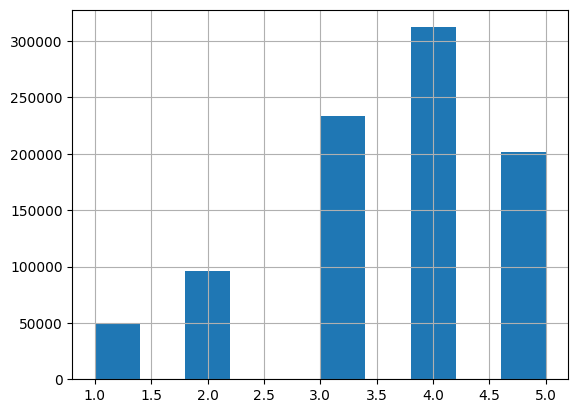

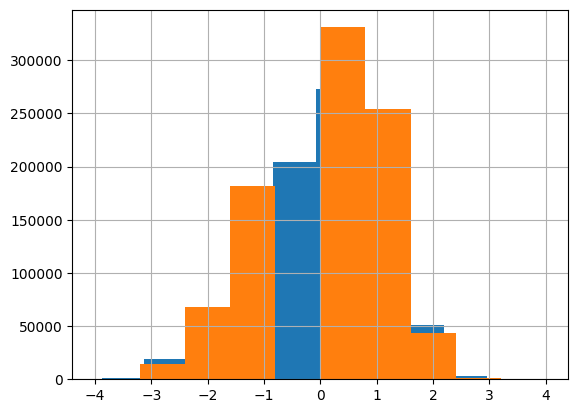

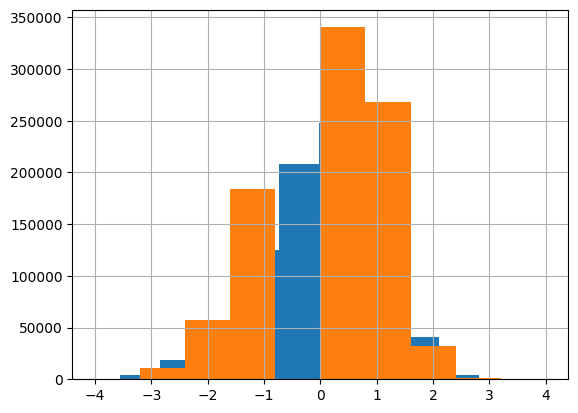

rating_user_normalized_round   -0.017844
rating_item_normalized_round    0.002703
dtype: float64

In [ ]:
df = events.copy()

# Общее количество доступных фильмов
num_total_items = df['item_id'].nunique()

positive_threshold = 4

# Агрегация по 'user_id'
user_features_group = df.groupby('user_id').agg(
    user_avg_rating=('rating', 'mean'),
    user_min_rating=('rating', 'min'),
    user_max_rating=('rating', 'max'),
    user_rating_count=('rating', 'count'),
    user_rating_std=('rating', 'std'),
    user_unique_items=('item_id', 'nunique'),
    user_start_time=('timestamp', 'min'),
    last_user_activity=('timestamp', 'max'),
    user_activity_timedelta=('timestamp', lambda x: x.diff().mean()),

    # Количество фильмов, которые пользователь оценил положительно
    user_positive_items=("rating", lambda x: (x >= positive_threshold).sum()),
    # Доля непросмотренных фильмов (если есть информация о всех доступных фильмах)
    user_unwatched_ratio=('item_id', lambda x: 1 - x.nunique() / num_total_items)


).reset_index()

# Добавление доли положительных оценок

user_positive_count = df[df['rating'] >= positive_threshold].groupby('user_id')['rating'].count()
user_features_group = user_features_group.merge(user_positive_count.rename('user_positive_rating_count'), on='user_id', how='left')
user_features_group['user_positive_rating_ratio'] = user_features_group['user_positive_rating_count'].fillna(0) / user_features_group['user_rating_count']

# Вычисление отклонения от среднего
overall_avg_rating = df['rating'].mean()
user_features_group['user_bias'] = user_features_group['user_avg_rating'] - overall_avg_rating

# Агрегация по 'item_id'
item_features_group = df.groupby('item_id').agg(
    item_avg_rating=('rating', 'mean'),
    item_min_rating=('rating', 'min'),
    item_max_rating=('rating', 'max'),
    item_rating_count=('rating', 'count'),
    item_unique_users=('user_id', 'nunique'),
    last_item_rating_time=('timestamp', 'max'),
    first_item_rating_time=('timestamp', 'min'),

    # Разнообразие оценок (например, число уникальных оценок)
    item_rating_diversity=('rating', 'nunique')
).reset_index()

# Добавление доли положительных оценок
item_positive_count = df[df['rating'] >= positive_threshold].groupby('item_id')['rating'].count()
item_features_group = item_features_group.merge(item_positive_count.rename('item_positive_rating_count'), on='item_id', how='left')
item_features_group['item_positive_rating_ratio'] = item_features_group['item_positive_rating_count'].fillna(0) / item_features_group['item_rating_count']

# Присоединение вычисленных признаков обратно к исходному датафрейму
df = df.merge(user_features_group, on='user_id', how='left')
df = df.merge(item_features_group, on='item_id', how='left')

# Вычисление текущей новизны просмотра фильма
df['item_recency'] = df['last_item_rating_time'] - df['timestamp']
# Вычисление текущей старины просмотра фильма
df['item_olden'] = df['timestamp'] - df['first_item_rating_time']


# Средний рейтинг, полученный фильмом за последние N оценок
N_list = list(range(2, 51, 2))
df_sorted = df.sort_values(by=['item_id', 'timestamp'], ascending=[True, False])
for n in N_list:
    df_sorted[f'top_{n}_avg_rating_item'] = df_sorted.groupby('item_id')['rating'].transform(lambda x: x.head(n).mean())
    df = df.join(df_sorted.set_index(['user_id', 'item_id'])[f'top_{n}_avg_rating_item'], on=['user_id', 'item_id'], rsuffix='_recent')
del df_sorted


# Средний рейтинг, поставленный пользователем на последние N фильмов
N_list = list(range(2, 51, 2))
df_sorted = df.sort_values(by=['user_id', 'timestamp'], ascending=[True, False])
for n in N_list:
    df_sorted[f'top_{n}_avg_rating_user'] = df_sorted.groupby('item_id')['rating'].transform(lambda x: x.head(n).mean())
    df = df.join(df_sorted.set_index(['user_id', 'item_id'])[f'top_{n}_avg_rating_user'], on=['user_id', 'item_id'], rsuffix='_recent')
del df_sorted


# Кумулятивная средняя оценка юзера
df['rating_user_cumsum'] = df.groupby('user_id')['rating'].cumsum()
df['rating_user_cumcount'] = df.groupby('user_id')['rating'].cumcount()
df['rating_user_cummean'] = (df['rating_user_cumsum'] / df['rating_user_cumcount']).replace(np.inf, 0)

# Кумулятивная средняя оценка фильма
df['rating_item_cumsum'] = df.groupby('item_id')['rating'].cumsum()
df['rating_item_cumcount'] = df.groupby('item_id')['rating'].cumcount()
df['rating_item_cummean'] = (df['rating_item_cumsum'] / df['rating_item_cumcount']).replace(np.inf, 0)



df.rating.hist()
plt.show()

# Отнормированный рейтинг по пользователю с учетом его средней оценки, на практике получаем классическое норм расп оценок из изначально не нормального
# (Обычно такой прием хорошо работает на опросниках людей)
df['rating_user_normalized'] = df['rating'] - df.groupby('user_id')['rating'].transform('mean')
df['rating_user_normalized_round'] = df['rating'] - df.groupby('user_id')['rating'].transform('mean').round(0)
df['rating_user_normalized'].hist(), df['rating_user_normalized_round'].hist()
plt.show()

# Отнормированный рейтинг по фильму с учетом его средней оценки
df['rating_item_normalized'] = df['rating'] - df.groupby('item_id')['rating'].transform('mean')
df['rating_item_normalized_round'] = df['rating'] - df.groupby('item_id')['rating'].transform('mean').round(0)
df['rating_item_normalized'].hist(), df['rating_item_normalized_round'].hist()
plt.show()

display(df[['rating_user_normalized_round', 'rating_item_normalized_round']].mean())

### Учет пола и возраста

In [ ]:
# Пол переводим в булевую
user_features['gender'] = user_features['gender'].map({'M':1, 'F':0})
df = df.merge(user_features, on='user_id', how='left')

# Возраст уже забинен в колонке, уникальных значений мало и они логически разбиты на этапы жизни челяди, поэтому оставляем как есть
# Считаем схожие фичи, но с условием агрегации на пол и возраст
gender_age_features = df.groupby(['gender', 'age']).agg(
    gender_age_avg_rating=('rating', 'mean'),
    gender_age_min_rating=('rating', 'min'),
    gender_age_max_rating=('rating', 'max'),
    gender_age_rating_count=('rating', 'count'),
    gender_age_unique_users=('user_id', 'nunique'),
    gender_age_start_time=('timestamp', 'min'),
    gender_age_last_activity=('timestamp', 'max'),
    gender_age_positive_items=('rating', lambda x: (x >= positive_threshold).sum())
).reset_index()

user_gender_age_features = df.groupby(['user_id', 'gender', 'age']).agg(
    user_gender_age_avg_rating=('rating', 'mean'),
    user_gender_age_min_rating=('rating', 'min'),
    user_gender_age_max_rating=('rating', 'max'),
    user_gender_age_rating_count=('rating', 'count'),
    user_gender_age_positive_items=('rating', lambda x: (x >= positive_threshold).sum())
).reset_index()

user_gender_age_variance = df.groupby(['gender', 'age'])['rating'].var().reset_index(name='gender_age_rating_variance')
user_gender_age_std = df.groupby(['gender', 'age'])['rating'].std().reset_index(name='gender_age_rating_std')

gender_age_positive_ratio = gender_age_features['gender_age_positive_items'] / gender_age_features['gender_age_rating_count']
gender_age_features['gender_age_positive_ratio'] = gender_age_positive_ratio

overall_gender_age_avg_rating = df.groupby(['gender', 'age'])['rating'].mean().reset_index(name='overall_gender_age_avg_rating')

# Объединяем gender_age_features с основным df
df = df.merge(gender_age_features, on=['gender', 'age'], how='left', suffixes=('', '_by_gender_age'))
# Объединяем user_gender_age_features с основным df
df = df.merge(user_gender_age_features, on=['user_id', 'gender', 'age'], how='left', suffixes=('', '_by_user_gender_age'))
# Объединяем с дисперсией и стандартным отклонением оценок
df = df.merge(user_gender_age_variance, on=['gender', 'age'], how='left')
df = df.merge(user_gender_age_std, on=['gender', 'age'], how='left')
df = df.merge(overall_gender_age_avg_rating, on=['gender', 'age'], how='left')

df['user_gender_age_bias'] = df['user_avg_rating'] - df['overall_gender_age_avg_rating']

In [ ]:
# ==== 1. ЖАНРОВЫЕ ФИЧИ ДЛЯ ПОЛЬЗОВАТЕЛЯ ====
genre_cols = [col for col in item_features.columns if col.startswith('genre_')]

# Присоединяем жанры к событиям
df = df.merge(item_features[['item_id'] + genre_cols], on='item_id', how='left')

# Агрегация жанров по пользователю
user_genre_pref = df.groupby('user_id')[genre_cols].mean().reset_index()
user_genre_pref.columns = ['user_id'] + [f'user_genre_pref_{g}' for g in genre_cols]

# Энтропия жанров пользователя
user_genre_pref['user_genre_entropy'] = user_genre_pref[
    [c for c in user_genre_pref.columns if c.startswith('user_genre_pref_')]
].apply(lambda row: -np.nansum(row * np.log(row + 1e-9)), axis=1)

df = df.merge(user_genre_pref, on='user_id', how='left')

# ==== 2. ЖАНРОВЫЕ ФИЧИ ДЛЯ АЙТЕМОВ ====
item_features_group['item_num_genres'] = item_features[genre_cols].sum(axis=1)
# Средний рейтинг по каждому жанру у пользователя
for g in genre_cols:
    df[f'user_avg_{g}'] = df.groupby('user_id').apply(
        lambda x: (x['rating'] * x[g]).sum() / x[g].sum() if x[g].sum() > 0 else np.nan
    ).reindex(df.index, method='ffill')

# ТОП-3 любимых жанра пользователя по количеству оценок
user_genre_counts = df.groupby('user_id')[genre_cols].sum()
df = df.merge(user_genre_counts, on='user_id', how='left', suffixes=('', '_user_total'))

# Является ли жанр айтема топ-3 для пользователя
def is_top3(row):
    top3 = row[[c + '_user_total' for c in genre_cols]].nlargest(3).index
    for g in genre_cols:
        if row[g] == 1 and g + '_user_total' in top3:
            return 1
    return 0

df['is_item_in_user_top3_genres'] = df.apply(is_top3, axis=1)


df = df.merge(item_features_group[['item_id', 'item_num_genres']], on='item_id', how='left')
df['item_is_single_genre'] = (df['item_num_genres'] == 1).astype(int)

# ==== 3. ПОПУЛЯРНОСТЬ И RECENCY ====
item_pop = df.groupby('item_id')['user_id'].count().reset_index(name='item_interactions')
item_pop['item_popularity_rank'] = item_pop['item_interactions'].rank(ascending=False)
df = df.merge(item_pop, on='item_id', how='left')

# ==== 4. TEMPORAL FEATURES ====
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s', errors='ignore')
df['hour_of_day'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.weekday
current_ts = df['timestamp'].max()
df['recency_decay'] = np.exp(-0.00001 * (current_ts - df['timestamp']))

# Признаки "усталости" от фильмов
df['user_repeats_items_ratio'] = df['user_rating_count'] / df['user_unique_items']

# Накопительная динамика эмоций
df['rating_delta_user'] = df.groupby('user_id')['rating'].diff()
df['rating_delta_item'] = df.groupby('item_id')['rating'].diff()

df['user_rating_interval'] = df.groupby('user_id')['timestamp'].diff()
df['user_activity_regularity'] = df.groupby('user_id')['user_rating_interval'].transform('std')

In [ ]:
# Растут оценки или падают
df['item_rating_trend'] = df.groupby('item_id')['rating'].transform(lambda x: x.diff().mean())

# Кластеризация по жанрам
#genre_cols = [f'genre_{i}' for i in range(18)]
#item_genres_matrix = df.drop_duplicates('item_id')[['item_id'] + genre_cols].set_index('item_id')
#kmeans = KMeans(n_clusters=8, random_state=42)
#item_genres_matrix['genre_cluster'] = kmeans.fit_predict(item_genres_matrix[genre_cols])

#df = df.merge(item_genres_matrix['genre_cluster'], on='item_id', how='left')

# Кол-во похожих фильмов по жанру, которые юзер смотрел раньше
df['has_user_seen_similar_items_before'] = (
    df.groupby('user_id')[genre_cols].cumsum().sum(axis=1) > 0
).astype(int)

# Интеракции user × genre, возраст × genre
for g in genre_cols:
    df[f'user_genre_pref*{g}'] = df[g] * df['user_avg_rating']
    df[f'user_age_item_{g}'] = df[g] * df['age']

# Отклонение от среднего на уровне пользователя (без повторов)
df['user_rating_deviation'] = df['rating'] - df['user_avg_rating']

# Айтемы, оценённые пользователем ровно 1 раз
user_item_counts = df.groupby(['user_id', 'item_id']).size().rename('user_item_interaction_count')
df = df.merge(user_item_counts, on=['user_id', 'item_id'], how='left')
df['user_n_items_rated_once'] = (df['user_item_interaction_count'] == 1).astype(int)

In [ ]:
df.to_csv('df_new_features.csv')

###  Split dataframe для базовых моделей

In [ ]:
# Снова переиндексируем items, так как изменилось их общее количество (train стал меньше)
train_data_glob['item_id_idx'], item_index = pd.factorize(train_data_glob['item_id_idx'])

In [ ]:
train_data, val_data, test_data = train_val_test_split(train_data_glob, val_size=0.1, test_size=0.1)

In [ ]:
n_users = train_data_glob['user_id_idx'].nunique()
n_items = train_data_glob['item_id_idx'].nunique()
print(n_users, n_items)

6040 3684


In [ ]:
# Создаем разреженные матрицы взаимодействий
train_matrix = create_sparse_matrix(train_data, n_users, n_items)
val_matrix = create_sparse_matrix(val_data, n_users, n_items)
test_matrix = create_sparse_matrix(test_data, n_users, n_items)

## ALS

In [ ]:
# Функция для расчета Recall@10
def recall_at_k(model, user_items, test_items, k=10):
    recalls = []
    for user_id in range(user_items.shape[0]):
        # Проверяем, обучен ли моделью этот пользователь
        if user_id >= model.user_factors.shape[0]:
            print(f"User miss in train: {user_id}")
            continue

        # Получаем рекомендации для пользователя
        recommended_items = model.recommend(user_id, user_items[user_id], N=k)
        recommended_item_ids = set(recommended_items[0])

        # Истинные айтемы (из теста)
        true_item_ids = set(test_items[user_id].nonzero()[1])

        # Пропускаем, если нет истинных айтемов
        if len(true_item_ids) == 0:
            continue

        # Считаем Recall
        recall = len(recommended_item_ids & true_item_ids) / len(true_item_ids)
        recalls.append(recall)

    return np.mean(recalls)

### поиск лучших параметров


In [ ]:
# Подбор гиперпараметров
param_grid = {
    'factors': [20, 50, 100, 150, 200, 300],
    'regularization': [0.01, 0.02, 0.05, 0.1],
    'iterations': [10, 15, 20]
}

best_score = -1
best_params = None


# Проходим по сетке параметров
for params in ParameterGrid(param_grid):
    model = AlternatingLeastSquares(factors=params['factors'], regularization=params['regularization'], iterations=params['iterations'], num_threads=8, random_state=42)
    model.fit(train_matrix, show_progress=False)

    score = recall_at_k(model, train_matrix, val_matrix, k=10)

    print(f"Параметры: {params}, Recall@10: {score}")

    if score > best_score:
        best_score = score
        best_params = params

print(f"Лучшие параметры: {best_params}, с Recall@10: {best_score}")

Параметры: {'factors': 20, 'iterations': 10, 'regularization': 0.01}, Recall@10: 0.07503666035950804
Параметры: {'factors': 20, 'iterations': 10, 'regularization': 0.02}, Recall@10: 0.07497595395774204
Параметры: {'factors': 20, 'iterations': 10, 'regularization': 0.05}, Recall@10: 0.07496373383790603
Параметры: {'factors': 20, 'iterations': 10, 'regularization': 0.1}, Recall@10: 0.07515137180700095
Параметры: {'factors': 20, 'iterations': 15, 'regularization': 0.01}, Recall@10: 0.07583648691264584
Параметры: {'factors': 20, 'iterations': 15, 'regularization': 0.02}, Recall@10: 0.07573163040050457
Параметры: {'factors': 20, 'iterations': 15, 'regularization': 0.05}, Recall@10: 0.07564214758751182
Параметры: {'factors': 20, 'iterations': 15, 'regularization': 0.1}, Recall@10: 0.07513047934405549
Параметры: {'factors': 20, 'iterations': 20, 'regularization': 0.01}, Recall@10: 0.07666824345632293
Параметры: {'factors': 20, 'iterations': 20, 'regularization': 0.02}, Recall@10: 0.0767261904

### Лучшие параметры и обучение на них


In [ ]:
best_params = {'factors': 50, 'iterations': 20, 'regularization': 0.02}
final_model = AlternatingLeastSquares(factors=best_params['factors'], regularization=best_params['regularization'], iterations=best_params['iterations'], num_threads=8, random_state=42)
final_model.fit(train_matrix_glob, show_progress=False)
test_recall = recall_at_k(final_model, train_matrix_glob, test_matrix_glob, k=10)
print(f"Recall@10 на тестовых данных: {test_recall}")

Recall@10 на тестовых данных: 0.0521012693156733


In [ ]:
#получения K рекомендаций с негативной выборкой
def get_top_k_with_negative_sampling(final_model, not_train_data_glob, not_train_matrix_glob, train_matrix, user_id, k=10, negative_size=100):
    user_rated_items_in_val_test = set(not_train_data_glob[not_train_data_glob['user_id_idx'] == user_id]['item_id_idx'])
    item_ids_val_test, scores_val_test = final_model.recommend(user_id, not_train_matrix_glob[user_id], N=len(user_rated_items_in_val_test), filter_already_liked_items=False)
    all_items = set(range(n_items))
    unrated_items = list(all_items - user_rated_items_in_val_test)
    item_ids, scores = final_model.recommend(user_id, train_matrix[user_id], N=k, items=unrated_items, filter_already_liked_items=True)
    unrated_items_again = list(all_items - user_rated_items_in_val_test - set(item_ids))
    rng = np.random.RandomState(42)
    sampled_unrated_items = rng.choice(unrated_items_again, size=negative_size * 2, replace=False)
    item_ids_neg, scores_neg = final_model.recommend(user_id, train_matrix[user_id], N=negative_size, items=sampled_unrated_items, filter_already_liked_items=True, recalculate_user=True)
    negative_scores_sorted = sorted(zip(item_ids_neg, scores_neg), key=lambda x: x[1], reverse=False)
    item_ids_neg = [i[0] for i in negative_scores_sorted[:negative_size]]
    scores_neg = [i[1] for i in negative_scores_sorted[:negative_size]]
    items_ids_all = np.append( np.append(item_ids, item_ids_val_test), item_ids_neg )
    scores_all = np.append( np.append(scores, scores_val_test), scores_neg )

    return items_ids_all, scores_all

In [ ]:
users_train_glob = list(train_data_glob['user_id_idx'].unique())
len(users_train_glob), n_users_glob

(6040, 6040)

In [ ]:
data_i = []

for i in tqdm(range(n_users)):
    user_id = users_train_glob[i]
    try:
        items_ids_all, scores_all = get_top_k_with_negative_sampling(final_model, not_train_data_glob, not_train_matrix_glob, train_matrix_glob, user_id, k=10, negative_size=100)
    except:
        print(user_id)

    for item_id, score in zip(items_ids_all, scores_all):
        data_i.append([user_id, item_id, score])


als_df = pd.DataFrame(data_i, columns=['user_id_idx', 'item_id_idx', 'score_als'])
print(als_df.head())

100%|██████████| 6040/6040 [00:44<00:00, 135.07it/s]


   user_id_idx  item_id_idx  score_als
0            0          445   1.172245
1            0          294   1.157861
2            0          483   1.113745
3            0          488   1.065042
4            0         1046   0.996226


In [ ]:
item_ids_correct = dict(zip(train_data_glob['item_id_idx'], train_data_glob['item_id']))
user_ids_correct = dict(zip(train_data_glob['user_id_idx'], train_data_glob['user_id']))

als_df['item_id'] = als_df['item_id_idx'].map(item_ids_correct)
als_df['user_id'] = als_df['user_id_idx'].map(user_ids_correct)

als_df.drop(['user_id_idx', 'item_id_idx'], axis=1, inplace=True)

als_df = als_df[['user_id', 'item_id', 'score_als']]

## Item Similarity

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm

# ----------  фичи (починенные) ----------

def calculate_item_similarity_norm(events: pd.DataFrame) -> pd.DataFrame:
    """
    Item-to-Item по косинусу, с вычитанием средних по пользователю.
    Возвращает: DataFrame ['user_id','item_id','score'] (чем выше — тем лучше).
    """
    need = {'user_id', 'item_id', 'rating'}
    missing = need - set(events.columns)
    if missing:
        raise ValueError(f"Missing columns in events: {missing}")

    df = events[['user_id','item_id','rating']].copy()

    # Нормализация рейтинга относительно среднего пользователя
    user_mean = df.groupby('user_id')['rating'].transform('mean')
    df['rating_user_normalized'] = df['rating'] - user_mean
    df['rating_user_normalized_round'] = df['rating_user_normalized'].round(0)

    # Пользователь-айтем матрица по нормализованным рейтингам
    user_item_matrix = (
        df.groupby(['user_id','item_id'])['rating_user_normalized']
          .mean()
          .unstack(fill_value=0)
    )

    # Косинусное сходство между айтемами
    sim = cosine_similarity(user_item_matrix.T)
    sim = pd.DataFrame(sim, index=user_item_matrix.columns, columns=user_item_matrix.columns)

    # Скор для user x item как произведение матрицы профиля на матрицу сходства айтемов
    scores = user_item_matrix.dot(sim)

    # Обнуляем (NaN) уже виденные пользователем айтемы
    scores_values = scores.values.copy()
    seen_mask = user_item_matrix.values.nonzero()
    scores_values[seen_mask] = np.nan

    flat = (
        pd.DataFrame(scores_values, index=scores.index, columns=scores.columns)
          .stack()
          .reset_index()
    )
    flat.columns = ['user_id', 'item_id', 'score']
    flat = flat.sort_values(['user_id','score'], ascending=[True, False], kind='mergesort')
    return flat


def calculate_item_similarity_last_n(events: pd.DataFrame, depth: int) -> pd.DataFrame:
    """
    Для каждого пользователя берём d-й с конца просмотренный item и рекомендуем похожие айтемы по косинусу.
    Возвращает: ['user_id','item_id','score'] с min-max нормировкой по всему столбцу.
    """
    need = {'user_id','item_id','rating','timestamp'}
    missing = need - set(events.columns)
    if missing:
        raise ValueError(f"Missing columns in events: {missing}")

    df = events[['user_id','item_id','rating','timestamp']].copy()

    # Пивот под косинус (сырой рейтинг; 0 как отсутствие взаимодействия)
    user_item = df.pivot_table(index='user_id', columns='item_id', values='rating', aggfunc='mean', fill_value=0)

    sim = cosine_similarity(user_item.T)
    sim_df = pd.DataFrame(sim, index=user_item.columns, columns=user_item.columns)

    # d-й с конца элемент в каждой группе (с ресетом индекса!)
    last_d = (
        df.sort_values(['user_id','timestamp'], kind='mergesort')
          .groupby('user_id', sort=False)
          .nth(-depth)
          .reset_index()[['user_id','item_id']]
    )

    recs = []
    for user_id, last_item in tqdm(last_d.itertuples(index=False), total=len(last_d), disable=False):
        if last_item in sim_df.columns:
            # Берём только положительные сходства
            vec = sim_df[last_item]
            vec = vec[vec > 0]
            if not vec.empty:
                # Перебор похожих айтемов
                for iid, s in vec.items():
                    recs.append({'user_id': user_id, 'item_id': iid, 'score': float(s)})

    if not recs:
        return pd.DataFrame(columns=['user_id','item_id','score'])

    recs = pd.DataFrame(recs)

    # Глобальная min-max нормировка (избегаем деления на ноль)
    min_s, max_s = recs['score'].min(), recs['score'].max()
    if pd.isna(min_s) or pd.isna(max_s) or max_s == min_s:
        recs['score'] = 0.0
    else:
        recs['score'] = (recs['score'] - min_s) / (max_s - min_s)
    return recs


# ---------- Новые фичи (починенные) ----------

def get_top_items(events: pd.DataFrame) -> pd.DataFrame:
    if 'item_id' not in events.columns:
        raise ValueError("Missing 'item_id' in events")
    counts = events['item_id'].value_counts().rename_axis('item_id').reset_index(name='count')
    return counts


def match_users(events: pd.DataFrame) -> pd.DataFrame:
    """
    Возвращает ['user_id','item_id','count'].
    """
    top_items = get_top_items(events)
    user_ids = pd.DataFrame({'user_id': events['user_id'].unique()})
    user_ids['key'] = 1
    top_items = top_items.copy()
    top_items['key'] = 1
    out = user_ids.merge(top_items, on='key', how='inner').drop(columns='key')
    return out  # ['user_id','item_id','count']


def get_user_top_genre(events: pd.DataFrame, item_features: pd.DataFrame) -> pd.DataFrame:
    """
    item_features: item_id + one-hot жанры в столбцах.
    """
    if 'item_id' not in item_features.columns:
        raise ValueError("item_features must contain 'item_id'")

    # Мерджим фичи к событиям
    merged = events.merge(item_features, on='item_id', how='left')

    # Оставим только жанровые столбцы (исключаем явные служебные/числовые)
    drop_cols = {'item_id', 'rating', 'timestamp', 'item_id_idx', 'user_id_idx'}
    genre_cols = [c for c in merged.columns if c not in drop_cols and c not in {'user_id'}]

    # На случай, если жанров нет
    if not genre_cols:
        return pd.DataFrame(columns=['user_id','top_genre'])

    counts = merged.groupby('user_id')[genre_cols].sum(numeric_only=True)
    top = counts.idxmax(axis=1).reset_index()
    top.columns = ['user_id', 'top_genre']
    return top


def get_top_items_by_genre(events: pd.DataFrame, item_features: pd.DataFrame) -> pd.DataFrame:
    """
    Для каждого жанра — топ айтемов по частоте в событиях.
    Возвращает ['genre','item_id','count'].
    """
    if 'item_id' not in item_features.columns:
        raise ValueError("item_features must contain 'item_id'")

    merged = events.merge(item_features, on='item_id', how='left')

    # Определяем жанровые столбцы (кроме item_id)
    genre_cols = [c for c in item_features.columns if c != 'item_id']
    out = []

    for g in genre_cols:
        if g not in merged.columns:
            continue
        sub = merged[merged[g] == 1]
        if sub.empty:
            continue
        cnt = sub['item_id'].value_counts().rename_axis('item_id').reset_index(name='count')
        cnt['genre'] = g
        out.append(cnt[['genre','item_id','count']])

    if not out:
        return pd.DataFrame(columns=['genre','item_id','count'])

    return pd.concat(out, ignore_index=True)


def match_user_genre_top_items(events: pd.DataFrame, item_features: pd.DataFrame) -> pd.DataFrame:
    """
    Для каждого пользователя берём его топ-жанр и к нему — топ айтемы жанра.
    Возвращает ['user_id','item_id','count'] с нормировкой count в [0,1].
    """
    user_top = get_user_top_genre(events, item_features)
    top_by_genre = get_top_items_by_genre(events, item_features)

    if user_top.empty or top_by_genre.empty:
        return pd.DataFrame(columns=['user_id','item_id','count'])

    recs = user_top.merge(top_by_genre, left_on='top_genre', right_on='genre', how='inner')
    recs = recs.drop(columns=['genre','top_genre'])

    if recs['count'].max() > 0:
        recs['count'] = recs['count'] / recs['count'].max()
    else:
        recs['count'] = 0.0

    return recs  # ['user_id','item_id','count']


# ---------- Объединение (починенное) ----------

def unite_i2i_stupid_top_popular(events: pd.DataFrame,
                                 item_features: pd.DataFrame,
                                 test_data_glob: pd.DataFrame,
                                 top_n: int,
                                 max_depth: int) -> pd.DataFrame:
    """
    Склеивает:
    - Item2Item-норм (score_item2item_NL)
    - Item2Item по последним d (score_last_d_NL, d=1..max_depth)
    - Топ-поп (score_top_pop_NL)
    - Жанровый топ (score_genre_top_items_NL)
    Потом делает маскирование: по каждому скорам оставляем топ-N на пользователя, + тестовые пары, + случайные.
    """
    # 1) i2i по нормализованным рейтингам
    user_item_scores_norm = calculate_item_similarity_norm(events)
    user_item_scores_norm = user_item_scores_norm.rename(columns={'score':'score_item2item_NL'})

    # 2) i2i относительно последних d айтемов
    frames = []
    for d in range(1, max_depth + 1):
        tmp = calculate_item_similarity_last_n(events, d).rename(columns={'score': f'score_last_{d}_NL'})
        frames.append(tmp)
    # outer-merge всех d-скоров
    if frames:
        user_item_scores = frames[0]
        for k in range(1, len(frames)):
            user_item_scores = user_item_scores.merge(frames[k], on=['user_id','item_id'], how='outer')
    else:
        user_item_scores = pd.DataFrame(columns=['user_id','item_id'])

    # 3) топ-популярные айтемы для всех пользователей
    top_pop_score = match_users(events).rename(columns={'count':'score_top_pop_NL'})

    # 4) жанровый топ
    user_genre_top_items = match_user_genre_top_items(events, item_features).rename(columns={'count':'score_genre_top_items_NL'})

    # 5) сводная таблица
    final_scores = (
        user_item_scores_norm
        .merge(user_item_scores, on=['user_id','item_id'], how='outer')
        .merge(top_pop_score, on=['user_id','item_id'], how='outer')
        .merge(user_genre_top_items, on=['user_id','item_id'], how='outer')
    )

    # Список колонок-скоров
    score_cols = [c for c in final_scores.columns if c not in {'user_id','item_id'}]

    # Приводим к числам
    for col in score_cols:
        final_scores[col] = pd.to_numeric(final_scores[col], errors='coerce')

    # Индекс пар для удобства выборок
    final_scores = final_scores.set_index(['user_id','item_id']).sort_index()

    # Тестовые пары (как MultiIndex)
    test_idx = pd.MultiIndex.from_frame(
        test_data_glob[['user_id','item_id']].drop_duplicates()
    )
    test_idx = test_idx.intersection(final_scores.index)

    rng = np.random.RandomState(42)

    # По каждому скору — оставляем топ-N на пользователя + тестовые + случайные из остатков
    for col in tqdm(score_cols):
        col_series = final_scores[col]

        # нули для NaN, чтобы nlargest работал, но помним, что потом мы всё равно маскируем
        work = col_series.fillna(-np.inf)

        # Топ-N на пользователя
        # groupby по первому уровню (user_id), берём nlargest по значению
        tops = (
            work.groupby(level=0, group_keys=False)
                .apply(lambda s: s.nlargest(top_n))
                .index
        )

        # Остаток — то, что не попало в tops и не в test_idx
        remaining = final_scores.index.difference(tops.union(test_idx))

        # Сколько случайных взять: пусть будет до 10×(|tops|+|test|)
        want = min(len(remaining), 10 * (len(tops) + len(test_idx)))
        random_idx = pd.Index(remaining)
        if want > 0 and len(random_idx) > 0:
            random_idx = random_idx[rng.choice(len(random_idx), size=want, replace=False)]
        else:
            random_idx = pd.Index([])

        keep_idx = tops.union(test_idx).union(random_idx)

        # Маскируем всё прочее в этом столбце
        mask_drop = ~final_scores.index.isin(keep_idx)
        final_scores.loc[mask_drop, col] = np.nan

    # Убираем строки, где ВСЕ скора NaN
    final_scores = final_scores.dropna(how='all', subset=score_cols).reset_index()

    return final_scores


In [ ]:
    pip install numpy==1.26.4

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
# Результат от ItemToItem
df_scores_i2i = unite_i2i_stupid_top_popular(train_data_glob, item_features, not_train_data_glob, 10, 5)

df_scores_i2i.head()

100%|██████████| 8/8 [55:08<00:00, 413.57s/it]


,user_id,item_id,score_item2item_NL,score_last_1_NL,score_last_2_NL,score_last_3_NL,score_last_4_NL,score_last_5_NL,score_top_pop_NL,score_genre_top_items_NL
0,0,13,NaN,NaN,NaN,NaN,NaN,0.067616,NaN,NaN
1,0,15,NaN,0.227770,NaN,NaN,NaN,NaN,NaN,NaN
2,0,16,NaN,0.464879,NaN,NaN,NaN,NaN,NaN,NaN
3,0,19,NaN,0.122957,NaN,NaN,NaN,NaN,NaN,NaN
4,0,23,NaN,NaN,NaN,NaN,NaN,NaN,108.0,NaN


## TopPop

In [ ]:
def recommend_item_top_popular(events, test_data, user_id, n_negative=10, top_n=10):
    item_popularity = events.groupby('item_id').size().reset_index(name='interaction_count')
    item_popularity = item_popularity.sort_values(by='interaction_count', ascending=False)
    watched_items = events[events['user_id'] == user_id]['item_id'].unique()
    item_popularity = item_popularity[~item_popularity['item_id'].isin(watched_items)]
    train_top_n = item_popularity
    train_top_n['user_id'] = user_id
    train_top_n = train_top_n[['user_id', 'item_id', 'interaction_count']]
    test_watched_items = test_data[test_data['user_id'] == user_id]['item_id'].unique()
    positive_samples = test_data[test_data['user_id'] == user_id][['user_id', 'item_id']]
    all_items = item_popularity['item_id'].unique()
    test_unwatched_items = np.setdiff1d(all_items, test_watched_items)
    rng = np.random.default_rng(42222)
    negative_items = rng.choice(test_unwatched_items, size=min(n_negative * len(test_watched_items), len(test_unwatched_items)), replace=False)
    negative_samples = pd.DataFrame({
        'user_id': user_id,
        'item_id': negative_items
    })

    combined_samples = pd.concat([positive_samples, negative_samples], ignore_index=True)
    final_df = combined_samples.merge(train_top_n[['item_id', 'interaction_count']], on='item_id', how='left')


    final_df = pd.concat([final_df, train_top_n.head(top_n)], ignore_index=True).drop_duplicates(subset=['item_id'])

    return final_df[['user_id', 'item_id', 'interaction_count']]


def recommend_item_top_popular_avg_rating(events, test_data, user_id, n_negative=10, top_n=10):
    item_average_rating = events.groupby('item_id')['rating'].mean().reset_index(name='average_rating')
    item_average_rating = item_average_rating.sort_values(by='average_rating', ascending=False)
    watched_items = events[events['user_id'] == user_id]['item_id'].unique()
    item_average_rating = item_average_rating[~item_average_rating['item_id'].isin(watched_items)]

    train_top_n = item_average_rating
    train_top_n['user_id'] = user_id
    train_top_n = train_top_n[['user_id', 'item_id', 'average_rating']]


    test_watched_items = test_data[test_data['user_id'] == user_id]['item_id'].unique()
    positive_samples = test_data[test_data['user_id'] == user_id][['user_id', 'item_id']]
    all_items = item_average_rating['item_id'].unique()
    test_unwatched_items = np.setdiff1d(all_items, test_watched_items)
    rng = np.random.default_rng(42)
    negative_items = rng.choice(test_unwatched_items, size=min(n_negative * len(test_watched_items), len(test_unwatched_items)), replace=False)
    negative_samples = pd.DataFrame({
        'user_id': user_id,
        'item_id': negative_items
    })


    combined_samples = pd.concat([positive_samples, negative_samples], ignore_index=True)
    final_df = combined_samples.merge(train_top_n[['item_id', 'average_rating']], on='item_id', how='left')
    final_df = pd.concat([final_df, train_top_n.head(top_n)], ignore_index=True).drop_duplicates(subset=['item_id'])

    return final_df[['user_id', 'item_id', 'average_rating']]


def recommend_top_popular_with_ratings(events, test_data, user_id, n_negative=10, top_n=10):
    item_popularity = events.groupby('item_id').agg({
        'user_id': 'count',
        'rating': 'mean'
    }).reset_index()
    item_popularity['score'] = item_popularity['user_id'] * item_popularity['rating']
    min_score = item_popularity['score'].min()
    max_score = item_popularity['score'].max()
    item_popularity['score'] = (item_popularity['score'] - min_score) / (max_score - min_score)
    watched_items = events[events['user_id'] == user_id]['item_id'].unique()
    item_popularity = item_popularity[~item_popularity['item_id'].isin(watched_items)]
    train_top_n = item_popularity.sort_values(by='score', ascending=False)
    train_top_n['user_id'] = user_id
    train_top_n = train_top_n[['user_id', 'item_id', 'score']]


    test_watched_items = test_data[test_data['user_id'] == user_id]['item_id'].unique()
    positive_samples = test_data[test_data['user_id'] == user_id].copy()
    positive_samples = positive_samples[['user_id', 'item_id']]

    all_items = item_popularity['item_id'].unique()
    test_unwatched_items = np.setdiff1d(all_items, test_watched_items)
    rng = np.random.default_rng(42)
    negative_items = rng.choice(test_unwatched_items, size=min(n_negative * len(test_watched_items), len(test_unwatched_items)), replace=False) # изменено
    negative_samples = pd.DataFrame({
        'user_id': user_id,
        'item_id': negative_items
    })

    combined_samples = pd.concat([positive_samples, negative_samples], ignore_index=True)
    final_df = combined_samples.merge(train_top_n[['item_id', 'score']], on='item_id', how='left')
    final_df = pd.concat([final_df, train_top_n.head(top_n)], ignore_index=True)

    return final_df[['user_id', 'item_id', 'score']]

In [ ]:
def recommend_top_and_bottom_popular_with_ratings(events, user_id, top_n=50, bottom_n=50):
    item_popularity = events.groupby('item_id').agg(
        interaction_count_dumb=('user_id', 'count'),
        average_rating=('rating', 'mean')
    ).reset_index()

    item_popularity['popularity_score_dumb'] = item_popularity['interaction_count_dumb'] * item_popularity['average_rating']

    watched_items = events[events['user_id'] == user_id]['item_id'].unique()
    item_popularity = item_popularity[~item_popularity['item_id'].isin(watched_items)]

    item_popularity = item_popularity.sort_values(by='popularity_score_dumb', ascending=False)

    top_popular = item_popularity.head(top_n)
    bottom_popular = item_popularity.tail(bottom_n)

    top_popular['user_id'] = user_id
    bottom_popular['user_id'] = user_id

    result = pd.concat([top_popular, bottom_popular], ignore_index=True)

    return result[['user_id', 'item_id', 'popularity_score_dumb']]

def recommend_top_and_bottom_by_average_rating(events, user_id, top_n=50, bottom_n=50):
    item_ratings = events.groupby('item_id').agg(
        average_rating_dumb=('rating', 'mean')
    ).reset_index()

    watched_items = events[events['user_id'] == user_id]['item_id'].unique()
    item_ratings = item_ratings[~item_ratings['item_id'].isin(watched_items)]

    item_ratings = item_ratings.sort_values(by='average_rating_dumb', ascending=False)

    top_rated = item_ratings.head(top_n)
    bottom_rated = item_ratings.tail(bottom_n)

    top_rated['user_id'] = user_id
    bottom_rated['user_id'] = user_id

    result = pd.concat([top_rated, bottom_rated], ignore_index=True)

    return result[['user_id', 'item_id', 'average_rating_dumb']]

In [ ]:
# Результаты
results_list = []

unique_users = train_data['user_id'].unique()

for user in unique_users:
    user_recommendations = recommend_item_top_popular(train_data_glob, not_train_data_glob, user_id=user, n_negative=10, top_n=20)
    results_list.append(user_recommendations)

final_results_df = pd.concat(results_list, ignore_index=True)



results_list = []

unique_users = train_data['user_id'].unique()

for user in unique_users:
    user_recommendations = recommend_item_top_popular_avg_rating(train_data_glob, not_train_data_glob, user_id=user, n_negative=10, top_n=20)
    results_list.append(user_recommendations)

final_results_df2 = pd.concat(results_list, ignore_index=True)




results_list = []

unique_users = train_data['user_id'].unique()

for user in unique_users:
    user_recommendations3 = recommend_top_popular_with_ratings(train_data_glob, not_train_data_glob, user_id=user, n_negative=10, top_n=20)
    results_list.append(user_recommendations3)

final_results_df3 = pd.concat(results_list, ignore_index=True)




results_list = []

unique_users = train_data['user_id'].unique()

for user in unique_users:
    user_recommendations3 = recommend_top_and_bottom_popular_with_ratings(train_data_glob, user_id=user, top_n=50, bottom_n=50)
    results_list.append(user_recommendations3)

final_results_df4 = pd.concat(results_list, ignore_index=True)




results_list = []

unique_users = train_data['user_id'].unique()

for user in unique_users:
    user_recommendations4 = recommend_top_and_bottom_by_average_rating(train_data_glob, user_id=user, top_n=50, bottom_n=50)
    results_list.append(user_recommendations4)

final_results_df5 = pd.concat(results_list, ignore_index=True)

In [ ]:
popular_df = final_results_df.merge(final_results_df2, on=['user_id', 'item_id'], how='outer') \
                             .merge(final_results_df3, on=['user_id', 'item_id'], how='outer') \
                             .merge(final_results_df4, on=['user_id', 'item_id'], how='outer') \
                             .merge(final_results_df5, on=['user_id', 'item_id'], how='outer')

popular_df.head(2)

,user_id,item_id,interaction_count,average_rating,score,popularity_score_dumb,average_rating_dumb
0,0,2239,229.0,3.187773,0.058069,NaN,NaN
1,0,2931,691.0,4.393632,0.241756,NaN,4.393632


In [ ]:
filter_i = (popular_df['interaction_count'].notna() | popular_df['average_rating'].notna() | popular_df['score'].notna())
popular_df = popular_df[filter_i]

print(popular_df.shape)
popular_df.head(2)

(1024521, 7)


,user_id,item_id,interaction_count,average_rating,score,popularity_score_dumb,average_rating_dumb
0,0,2239,229.0,3.187773,0.058069,NaN,NaN
1,0,2931,691.0,4.393632,0.241756,NaN,4.393632


# Faiss

In [ ]:

user_events = train_data_glob.groupby('user_id')['item_id'].apply(set).to_dict()
train_matrix_dense = train_matrix_glob.toarray().astype('float32')
not_train_matrix_dense = not_train_matrix_glob.toarray().astype('float32')


k = 30
dimension = train_matrix_dense.shape[1]
gpu_index_l2 = faiss.IndexFlatL2(dimension)
gpu_index_ip = faiss.IndexFlatIP(dimension)
gpu_index_l2.add(train_matrix_dense)
gpu_index_ip.add(train_matrix_dense)
distances_l2, indices_l2 = gpu_index_l2.search(not_train_matrix_dense, k)
distances_ip, indices_ip = gpu_index_ip.search(not_train_matrix_dense, k)


recommendations_l2 = []
for user_id in tqdm(range(not_train_matrix_dense.shape[0]), desc="Обработка L2"):
    seen_items = user_events.get(user_id, set())
    for neighbor_idx in range(k):
        item_id = indices_l2[user_id][neighbor_idx]
        if item_id not in seen_items:
            distance = distances_l2[user_id][neighbor_idx]
            score_l2 = 1 / (distance + 1e-5)
            recommendations_l2.append((user_id, item_id, score_l2))


recommendations_ip = []
for user_id in tqdm(range(not_train_matrix_dense.shape[0]), desc="Обработка IP"):
    seen_items = user_events.get(user_id, set())
    for neighbor_idx in range(k):
        item_id = indices_ip[user_id][neighbor_idx]
        if item_id not in seen_items:
            distance = distances_ip[user_id][neighbor_idx]
            score_ip = 1 / (distance + 1e-5)
            recommendations_ip.append((user_id, item_id, score_ip))

df_l2 = pd.DataFrame(recommendations_l2, columns=['user_id', 'item_id', 'score_l2'])
df_ip = pd.DataFrame(recommendations_ip, columns=['user_id', 'item_id', 'score_ip'])


df_faiss = pd.merge(df_l2, df_ip, on=['user_id', 'item_id'], how='outer')
df_faiss['score_total'] = df_faiss[['score_l2', 'score_ip']].apply(
    lambda x: hmean(x.dropna()) if not x.isnull().any() else np.nan, axis=1)
scaler = MinMaxScaler()
df_faiss[['score_total', 'score_l2', 'score_ip']] = scaler.fit_transform(df_faiss[['score_total', 'score_l2', 'score_ip']])

Обработка IP: 100%|██████████| 6040/6040 [00:00<00:00, 10409.12it/s]


In [ ]:
print(df_faiss.shape)
df_faiss.head(2)

(354993, 5)


,user_id,item_id,score_l2,score_ip,score_total
0,0,5408,0.115658,NaN,NaN
1,0,1780,0.109474,NaN,NaN


## KNN

#### Функция для расчета Recall@k с прогресс-баром

In [ ]:
def recall_at_k_knn(val_matrix, recommendations, k=10, n_jobs=-1):
    num_users = val_matrix.shape[0]

    def user_recall(user_id):
        true_items = set(val_matrix[user_id].indices)
        recommended_items = set(recommendations[user_id])
        hits = len(true_items & recommended_items)
        recall = hits / len(true_items) if len(true_items) > 0 else 0
        return recall

    recommendations = [set(map(tuple, rec)) if isinstance(rec[0], list) else set(rec) for rec in recommendations]
    recalls = Parallel(n_jobs=n_jobs)(
        delayed(user_recall)(i) for i in tqdm(range(num_users), desc="Calculating Recall@k")
    )

    return np.mean(recalls)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from scipy import sparse
from tqdm.notebook import tqdm as tqdm_notebook

def knn_user_based_recommendations_df(train_matrix, drop_items_df, k=30, metric=None, n_jobs=-1, algorithm=None):
    # Преобразуем разреженную матрицу в плотный формат (как у тебя)
    train_matrix_dense = train_matrix.toarray() if not isinstance(train_matrix, np.ndarray) else train_matrix
    n_users, n_items = train_matrix_dense.shape

    # Модель ближайших соседей
    n_neighbors = min(k + 1, n_users)
    model = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, algorithm='brute', n_jobs=n_jobs)
    model.fit(train_matrix_dense)

    # Все соседи сразу
    distances_all, indices_all = model.kneighbors(train_matrix_dense, return_distance=True)
    neigh_indices = indices_all[:, 1:]
    neigh_distances = distances_all[:, 1:]

    # Просмотренное
    user_events = drop_items_df.groupby('user_id')['item_id'].apply(set).to_dict()

    # Матрица W (users x users): единицы на местах (u, neighbor_of_u)
    rows = np.repeat(np.arange(n_users), neigh_indices.shape[1])
    cols = neigh_indices.ravel()
    data = np.ones_like(cols, dtype=np.float32)
    W = sparse.coo_matrix((data, (rows, cols)), shape=(n_users, n_users)).tocsr()

    # Сумма по соседям
    summed_by_neighbors = W @ train_matrix_dense  # (n_users x n_items)

    rec_rows = []
    for u in tqdm_notebook(range(n_users), desc="Generating Recommendations"):
        scores = summed_by_neighbors[u].copy()

        # безопасная фильтрация индексов
        watched_items = user_events.get(u, set())
        if watched_items:
            idx = np.fromiter((int(i) for i in watched_items), dtype=int, count=len(watched_items))
            # оставляем только существующие столбцы
            idx = idx[(idx >= 0) & (idx < n_items)]
            if idx.size:
                scores[idx] = -np.inf
        # ----------------------------------------------------------------

        if not np.isfinite(scores).any():
            continue

        # Топ-k
        top_idx = np.argpartition(-scores, kth=min(k, n_items - 1))[:k]
        top_idx = top_idx[np.argsort(-scores[top_idx])]
        top_scores = scores[top_idx]

        # distance берём «как у тебя»: первые L расстояний соседей
        dists = neigh_distances[u][:len(top_idx)]

        for it, sc, dd in zip(top_idx, top_scores, dists):
            rec_rows.append((u, int(it), float(sc), float(dd)))

    df_recommendations = pd.DataFrame(rec_rows, columns=['user_id', 'item_id', 'score', 'distance'])

    # делаем формат под твой грид: [ ((user_id, item_id), distance), ... ]
    pairs = list(df_recommendations[['user_id', 'item_id']].itertuples(index=False, name=None))
    dists = df_recommendations['distance'].tolist()
    return list(zip(pairs, dists))


перебор гиперпараметров


In [ ]:
def grid_search_knn_user_based(train_matrix, val_matrix,drop_items_df, k, metrics, algorithms, n_jobs=12):
    best_recall = 0
    best_params = None
    history = []


    for metric in metrics:
        for algorithm in algorithms:
            if metric not in VALID_METRICS.get(algorithm, []):
                print(f"Skipping incompatible combination: metric={metric}, algorithm={algorithm}")
                continue

            print(f"Trying k={k}, metric={metric}, algorithm={algorithm}")
            try:
                user_recommendations_with_distances = knn_user_based_recommendations_df(train_matrix,drop_items_df, k=k, metric=metric, n_jobs=n_jobs, algorithm='brute')
                user_recommendations = [rec for rec, dist in user_recommendations_with_distances]
                recall_user_based = recall_at_k_knn(val_matrix, user_recommendations, k=10, n_jobs=n_jobs)
                history.append({
                    'metric': metric,
                    'algorithm': algorithm,
                    'recall': recall_user_based
                })


                if recall_user_based > best_recall:
                    best_recall = recall_user_based
                    best_params = {'metric': metric, 'algorithm': algorithm}

                print(f"Current best recall: {best_recall} with params {best_params}\n")

            except ValueError as e:
                print(f"Error with metric={metric}, algorithm={algorithm}: {e}")

    return best_recall, best_params, history

In [ ]:
k_values = [50]
metrics = ['cosine', 'euclidean', 'manhattan']
algorithms = ['ball_tree', 'kd_tree', 'brute']

best_recall, best_params, history = grid_search_knn_user_based(train_matrix, val_matrix,drop_items_df=events, k=10, metrics=metrics, n_jobs=6,algorithms=algorithms)

print(f"\nBest Recall@10: {best_recall}")
print(f"Best Parameters: {best_params}")

Skipping incompatible combination: metric=cosine, algorithm=ball_tree
Skipping incompatible combination: metric=cosine, algorithm=kd_tree
Trying k=10, metric=cosine, algorithm=brute


Generating Recommendations:   0%|          | 0/6040 [00:00<?, ?it/s]

Calculating Recall@k: 100%|██████████| 6040/6040 [02:01<00:00, 49.87it/s] 


Current best recall: 0.0028602964364553766 with params {'metric': 'cosine', 'algorithm': 'brute'}

Trying k=10, metric=euclidean, algorithm=ball_tree


Generating Recommendations:   0%|          | 0/6040 [00:00<?, ?it/s]

Calculating Recall@k: 100%|██████████| 6040/6040 [01:03<00:00, 95.66it/s] 


Current best recall: 0.0032860296436455377 with params {'metric': 'euclidean', 'algorithm': 'ball_tree'}

Trying k=10, metric=euclidean, algorithm=kd_tree


Generating Recommendations:   0%|          | 0/6040 [00:00<?, ?it/s]

Calculating Recall@k: 100%|██████████| 6040/6040 [01:02<00:00, 96.84it/s] 


Current best recall: 0.0032860296436455377 with params {'metric': 'euclidean', 'algorithm': 'ball_tree'}

Trying k=10, metric=euclidean, algorithm=brute


Generating Recommendations:   0%|          | 0/6040 [00:00<?, ?it/s]

Calculating Recall@k: 100%|██████████| 6040/6040 [01:01<00:00, 98.02it/s] 


Current best recall: 0.0032860296436455377 with params {'metric': 'euclidean', 'algorithm': 'ball_tree'}

Trying k=10, metric=manhattan, algorithm=ball_tree


Generating Recommendations:   0%|          | 0/6040 [00:00<?, ?it/s]

Calculating Recall@k: 100%|██████████| 6040/6040 [01:02<00:00, 97.14it/s] 


Current best recall: 0.0032860296436455377 with params {'metric': 'euclidean', 'algorithm': 'ball_tree'}

Trying k=10, metric=manhattan, algorithm=kd_tree


Generating Recommendations:   0%|          | 0/6040 [00:00<?, ?it/s]

Calculating Recall@k: 100%|██████████| 6040/6040 [01:02<00:00, 96.88it/s] 


Current best recall: 0.0032860296436455377 with params {'metric': 'euclidean', 'algorithm': 'ball_tree'}

Trying k=10, metric=manhattan, algorithm=brute


Generating Recommendations:   0%|          | 0/6040 [00:00<?, ?it/s]

Calculating Recall@k: 100%|██████████| 6040/6040 [01:02<00:00, 97.31it/s] 


Current best recall: 0.0032860296436455377 with params {'metric': 'euclidean', 'algorithm': 'ball_tree'}


Best Recall@10: 0.0032860296436455377
Best Parameters: {'metric': 'euclidean', 'algorithm': 'ball_tree'}


In [ ]:
recomemendations_df_knn = knn_user_based_recommendations_df(train_matrix=train_matrix_glob, drop_items_df=train_data_glob, k=50, metric='cosine', n_jobs=12)

Generating Recommendations:   0%|          | 0/6040 [00:00<?, ?it/s]

In [ ]:
pairs, dists = zip(*recomemendations_df_knn)   # <-- ВАЖНО: zip(*...)
pairs = list(pairs)
dists = list(dists)

f_recommendations = pd.DataFrame(
    [(u, i, np.nan, d) for (u, i), d in zip(pairs, dists)],
    columns=['user_id', 'item_id', 'score', 'distance']
)

# Кластеризация

In [ ]:
train_matrix_dense = train_matrix_glob.toarray()
cluster_range = range(2, 21)
sse_kmeans = []  # Sum of Squared Errors для KMeans (метод локтя)
silhouette_kmeans = []  # Силуэтный коэффициент для KMeans
silhouette_agg = []  # Силуэтный коэффициент для иерархической кластеризации
silhouette_dbscan = []  # Силуэтный коэффициент для DBSCAN

In [ ]:

for n_clusters in tqdm(cluster_range, desc="Clustering:"):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(train_matrix_dense)
    sse_kmeans.append(kmeans.inertia_)
    silhouette_avg_kmeans = silhouette_score(train_matrix_dense, kmeans.labels_)
    silhouette_kmeans.append(silhouette_avg_kmeans)
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    labels_agg = agg_clustering.fit_predict(train_matrix_dense)
    silhouette_avg_agg = silhouette_score(train_matrix_dense, labels_agg)
    silhouette_agg.append(silhouette_avg_agg)

Clustering:: 100%|██████████| 19/19 [23:48<00:00, 75.18s/it]


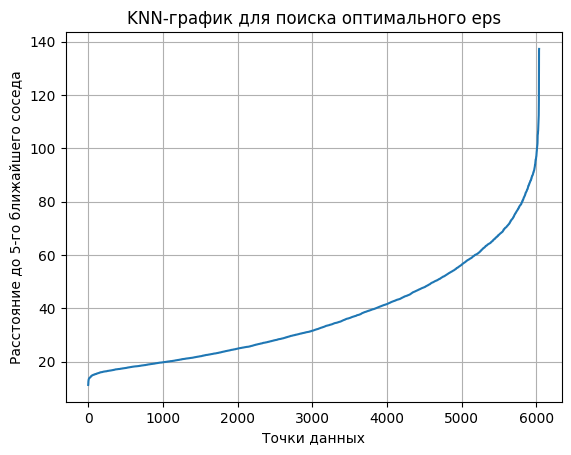

In [ ]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(train_matrix_dense)
distances, indices = neighbors_fit.kneighbors(train_matrix_dense)
distances = np.sort(distances[:, 4], axis=0)


plt.plot(distances)
plt.title("KNN-график для поиска оптимального eps")
plt.xlabel("Точки данных")
plt.ylabel("Расстояние до 5-го ближайшего соседа")
plt.grid(True)
plt.show()

In [ ]:
# DBSCAN
dbscan = DBSCAN(eps=50, min_samples=3)
labels_dbscan = dbscan.fit_predict(train_matrix_dense)
silhouette_avg_dbscan = silhouette_score(train_matrix_dense, labels_dbscan) if len(set(labels_dbscan)) > 1 else -1
silhouette_dbscan.append(silhouette_avg_dbscan)

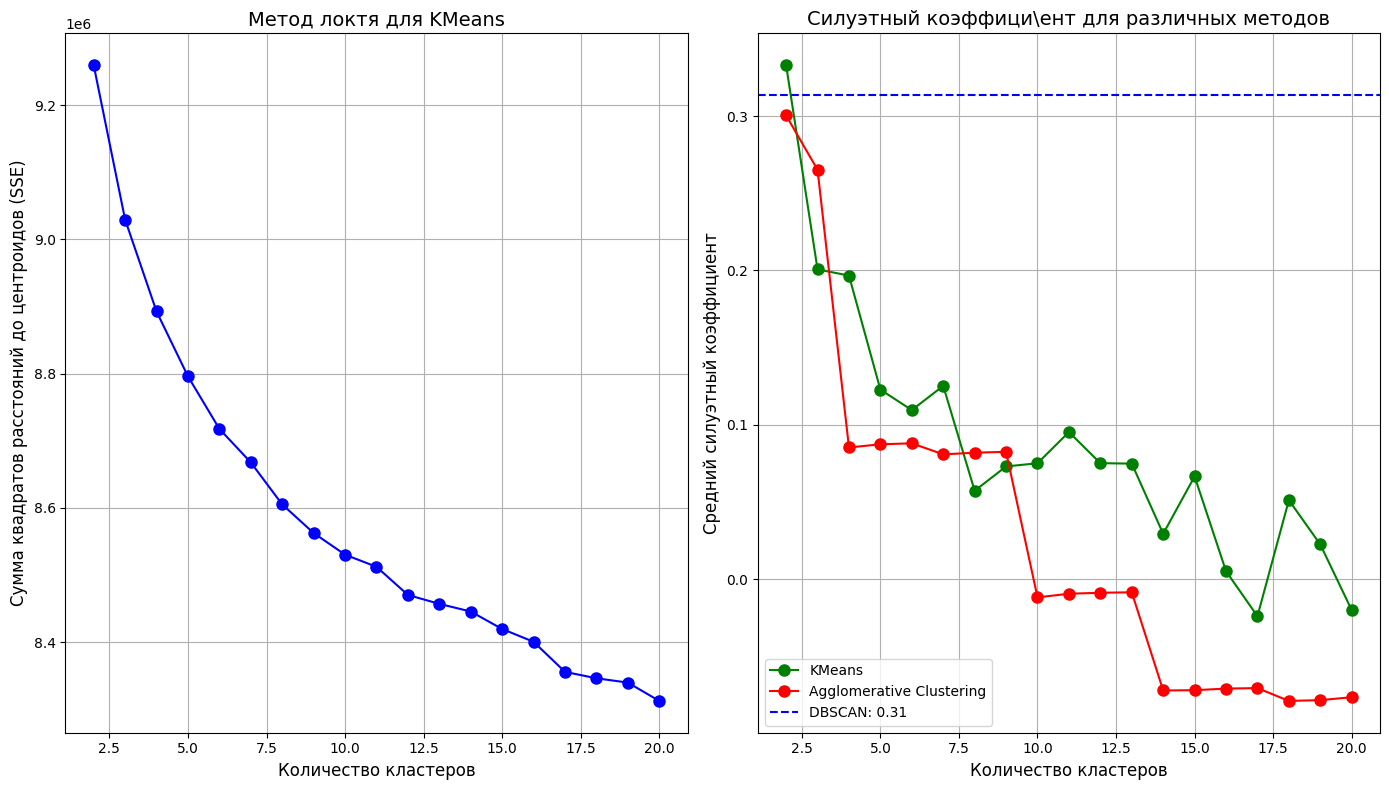

In [ ]:
# Построение графиков
plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, sse_kmeans, 'bo-', markersize=8)
plt.title('Метод локтя для KMeans', fontsize=14)
plt.xlabel('Количество кластеров', fontsize=12)
plt.ylabel('Сумма квадратов расстояний до центроидов (SSE)', fontsize=12)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_kmeans, 'go-', markersize=8, label='KMeans')
plt.plot(cluster_range, silhouette_agg, 'ro-', markersize=8, label='Agglomerative Clustering')
plt.axhline(y=silhouette_avg_dbscan, color='b', linestyle='--', label=f'DBSCAN: {silhouette_avg_dbscan:.2f}')
plt.title('Силуэтный коэффици\ент для различных методов', fontsize=14)
plt.xlabel('Количество кластеров', fontsize=12)
plt.ylabel('Средний силуэтный коэффициент', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
best_n_clusters = 10

kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
clusters_kmeans = kmeans.fit_predict(train_matrix_dense)

agg_clustering = AgglomerativeClustering(n_clusters=best_n_clusters)
clusters_agg = agg_clustering.fit_predict(train_matrix_dense)

dbscan = DBSCAN(eps=50, min_samples=5)
clusters_dbscan = dbscan.fit_predict(train_matrix_dense)

df_clusters = pd.DataFrame({
    'user_id': np.arange(train_matrix_dense.shape[0]),
    f'kmeans_{best_n_clusters}': clusters_kmeans,
    f'agg_{best_n_clusters}': clusters_agg,
    'dbscan': clusters_dbscan
})

print(df_clusters.shape)
df_clusters.head(2)

(6040, 4)


,user_id,kmeans_10,agg_10,dbscan
0,0,6,1,-1
1,1,6,1,-1


## Сбор общего датасета для бустинга

In [ ]:
df_scores_i2i

,user_id,item_id,score_item2item_NL,score_last_1_NL,score_last_2_NL,score_last_3_NL,score_last_4_NL,score_last_5_NL,score_top_pop_NL,score_genre_top_items_NL
0,0,13,NaN,NaN,NaN,NaN,NaN,0.067616,NaN,NaN
1,0,15,NaN,0.227770,NaN,NaN,NaN,NaN,NaN,NaN
2,0,16,NaN,0.464879,NaN,NaN,NaN,NaN,NaN,NaN
3,0,19,NaN,0.122957,NaN,NaN,NaN,NaN,NaN,NaN
4,0,23,NaN,NaN,NaN,NaN,NaN,NaN,108.0,NaN
...,...,...,...,...,...,...,...,...,...,...
7956177,6039,3694,NaN,0.541415,NaN,NaN,NaN,NaN,NaN,NaN
7956178,6039,3695,NaN,NaN,NaN,0.143514,NaN,NaN,NaN,NaN
7956179,6039,3700,NaN,NaN,NaN,NaN,NaN,0.157566,NaN,NaN
7956180,6039,3701,NaN,NaN,NaN,0.077587,NaN,NaN,NaN,NaN


In [ ]:
popular_df

,user_id,item_id,interaction_count,average_rating,score,popularity_score_dumb,average_rating_dumb
0,0,2239,229.0,3.187773,0.058069,NaN,NaN
1,0,2931,691.0,4.393632,0.241756,NaN,4.393632
2,0,1795,359.0,3.130919,0.089454,NaN,NaN
3,0,2568,384.0,3.898438,0.119165,NaN,NaN
4,0,1533,311.0,3.247588,0.080373,NaN,NaN
...,...,...,...,...,...,...,...
1024523,6035,1279,NaN,NaN,0.497929,6252.0,4.415254
1024524,6037,1316,NaN,NaN,0.610483,7665.0,NaN
1024525,6038,487,NaN,NaN,0.328342,4123.0,NaN
1024526,6039,3692,NaN,NaN,0.464235,5829.0,NaN


In [ ]:
df_clusters

,user_id,kmeans_10,agg_10,dbscan
0,0,6,1,-1
1,1,6,1,-1
2,2,8,0,0
3,3,6,1,0
4,4,4,9,0
...,...,...,...,...
6035,6035,8,0,0
6036,6036,2,5,0
6037,6037,2,9,0
6038,6038,9,2,-1


In [ ]:
all_models_df = als_df.merge(df_scores_i2i, on=['user_id', 'item_id'], how='outer')\
                        .merge(popular_df, on=['user_id', 'item_id'], how='outer')\
                        .merge(df_clusters, on=['user_id'], how='outer')\
                        .merge(f_recommendations, on=['user_id', 'item_id'], how='outer')\

In [ ]:
df_scores_i2i['item_id'].max(), popular_df['item_id'].max(), \
df_clusters['user_id'].max(), df_faiss['item_id'].max(), \
f_recommendations['item_id'].max()

(3705, 3705, 6039, 6039, 2957)

In [ ]:
all_models_df = all_models_df.drop_duplicates(subset=['user_id', 'item_id'], keep='first')

In [ ]:
all_models_df[['user_id', 'item_id']].duplicated().sum()

0

In [ ]:
all_models_df = all_models_df.merge(item_features, on='item_id', how='left')

In [ ]:
events['item_id'].max()

3705

In [ ]:
all_models_df.shape

(8691186, 40)

In [ ]:
df_user = df[['user_id', 'user_avg_rating', 'user_min_rating', 'user_max_rating', 'user_rating_count',
              'user_rating_std', 'user_unique_items', 'user_start_time', 'last_user_activity', 'user_activity_timedelta', 'user_positive_items',
              'user_unwatched_ratio', 'user_positive_rating_count', 'user_positive_rating_ratio', 'user_bias', 'rating_user_cummean',
              'rating_user_normalized', 'rating_user_normalized_round', 'gender', 'age', 'gender_age_avg_rating',
              'top_2_avg_rating_user', 'top_4_avg_rating_user',
              'top_6_avg_rating_user', 'top_8_avg_rating_user', 'top_10_avg_rating_user', 'top_12_avg_rating_user', 'top_14_avg_rating_user',
              'top_16_avg_rating_user', 'top_18_avg_rating_user', 'top_20_avg_rating_user', 'top_22_avg_rating_user', 'top_24_avg_rating_user',
              'top_26_avg_rating_user', 'top_28_avg_rating_user', 'top_30_avg_rating_user', 'top_32_avg_rating_user', 'top_34_avg_rating_user',
              'top_36_avg_rating_user', 'top_38_avg_rating_user', 'top_40_avg_rating_user', 'top_42_avg_rating_user', 'top_44_avg_rating_user',
              'top_46_avg_rating_user', 'top_48_avg_rating_user', 'top_50_avg_rating_user', 'rating_user_cumsum', 'rating_user_cumcount',
              'gender_age_min_rating', 'gender_age_max_rating', 'gender_age_rating_count', 'gender_age_unique_users', 'gender_age_start_time',
              'gender_age_last_activity', 'gender_age_positive_items', 'gender_age_positive_ratio', 'user_gender_age_avg_rating',
              'user_gender_age_min_rating', 'user_gender_age_max_rating', 'user_gender_age_rating_count', 'user_gender_age_positive_items',
              'gender_age_rating_variance', 'gender_age_rating_std', 'overall_gender_age_avg_rating', 'user_gender_age_bias']]

df_user = df_user.groupby(by='user_id').last().reset_index()

df_item = df[list(set(df.columns) - set(df_user.columns) - set(['rating', 'item_id_idx', 'timestamp','user_id_idx']))]
df_item = df_item.groupby(by='item_id').last().reset_index()

In [ ]:
all_models_df = all_models_df.merge(df_user, how='left', on='user_id')\
                             .merge(df_item, how='left', on='item_id')

print(all_models_df.shape)


print(all_models_df.shape)

(8691186, 274)
(8691186, 274)


In [ ]:
all_models_df.to_parquet('all_models_df_v2.parquet')

In [ ]:
not_train_data_glob['target'] = 1
all_models_df = all_models_df.merge(not_train_data_glob[['user_id', 'item_id', 'target']], on=['user_id', 'item_id'], how='left')
all_models_df['target'] = all_models_df['target'].fillna(0)
all_models_df['target'].value_counts(), not_train_data_glob.shape[0]

(0.0    8691186
 Name: target, dtype: int64,
 71938)

In [ ]:
all_models_df

,user_id,item_id,score_als,score_item2item_NL,score_last_1_NL,score_last_2_NL,score_last_3_NL,score_last_4_NL,score_last_5_NL,score_top_pop_NL,score_genre_top_items_NL,interaction_count,average_rating,score_x,popularity_score_dumb,average_rating_dumb,kmeans_10,agg_10,dbscan,score_y,distance,flag,genre_0_x,genre_1_x,genre_2_x,genre_3_x,genre_4_x,genre_5_x,genre_6_x,genre_7_x,genre_8_x,genre_9_x,genre_10_x,genre_11_x,genre_12_x,genre_13_x,genre_14_x,genre_15_x,genre_16_x,genre_17_x,user_avg_rating,user_min_rating,user_max_rating,user_rating_count,user_rating_std,user_unique_items,user_start_time,last_user_activity,user_activity_timedelta,user_positive_items,user_unwatched_ratio,user_positive_rating_count,user_positive_rating_ratio,user_bias,rating_user_cummean,rating_user_normalized,rating_user_normalized_round,gender,age,gender_age_avg_rating,top_2_avg_rating_user,top_4_avg_rating_user,top_6_avg_rating_user,top_8_avg_rating_user,top_10_avg_rating_user,top_12_avg_rating_user,top_14_avg_rating_user,top_16_avg_rating_user,top_18_avg_rating_user,top_20_avg_rating_user,top_22_avg_rating_user,top_24_avg_rating_user,top_26_avg_rating_user,top_28_avg_rating_user,top_30_avg_rating_user,top_32_avg_rating_user,top_34_avg_rating_user,top_36_avg_rating_user,top_38_avg_rating_user,top_40_avg_rating_user,top_42_avg_rating_user,top_44_avg_rating_user,top_46_avg_rating_user,top_48_avg_rating_user,top_50_avg_rating_user,rating_user_cumsum,rating_user_cumcount,gender_age_min_rating,gender_age_max_rating,gender_age_rating_count,gender_age_unique_users,gender_age_start_time,gender_age_last_activity,gender_age_positive_items,gender_age_positive_ratio,user_gender_age_avg_rating,user_gender_age_min_rating,user_gender_age_max_rating,user_gender_age_rating_count,user_gender_age_positive_items,gender_age_rating_variance,gender_age_rating_std,overall_gender_age_avg_rating,user_gender_age_bias,top_30_avg_rating_item,top_20_avg_rating_item,user_age_item_genre_1,user_genre_pref_genre_0,user_genre_pref*genre_3,user_genre_pref*genre_16,top_34_avg_rating_item,user_genre_pref_genre_12,user_genre_pref_genre_15,user_genre_pref*genre_0,genre_8_y,item_avg_rating,user_rating_interval,user_genre_pref*genre_9,user_genre_pref_genre_4,user_genre_pref_genre_5,top_4_avg_rating_item,genre_15_user_total,genre_5_y,user_avg_genre_5,user_age_item_genre_4,user_age_item_genre_0,item_positive_rating_ratio,user_genre_pref_genre_17,top_12_avg_rating_item,user_genre_pref*genre_7,user_genre_pref*genre_17,item_min_rating,genre_10_y,item_is_single_genre,datetime,first_item_rating_time,item_olden,top_28_avg_rating_item,item_unique_users,genre_12_y,genre_13_user_total,top_42_avg_rating_item,rating_item_cumcount,has_user_seen_similar_items_before,user_age_item_genre_6,user_avg_genre_11,user_genre_pref*genre_14,user_age_item_genre_5,genre_3_y,genre_11_y,user_repeats_items_ratio,rating_delta_user,user_genre_pref_genre_9,genre_1_user_total,top_22_avg_rating_item,genre_7_y,rating_delta_item,genre_13_y,genre_7_user_total,top_36_avg_rating_item,user_genre_pref*genre_5,user_genre_pref*genre_11,user_avg_genre_4,user_avg_genre_9,user_avg_genre_15,top_2_avg_rating_item,user_avg_genre_3,user_genre_pref*genre_1,genre_14_user_total,user_rating_deviation,genre_8_user_total,user_age_item_genre_12,top_16_avg_rating_item,genre_9_user_total,user_genre_pref*genre_8,genre_0_y,genre_2_user_total,item_num_genres,item_rating_diversity,user_genre_pref*genre_15,genre_1_y,user_avg_genre_13,user_avg_genre_6,user_avg_genre_8,genre_11_user_total,rating_item_cumsum,user_age_item_genre_13,user_genre_pref_genre_1,user_avg_genre_10,genre_10_user_total,user_genre_pref_genre_7,item_max_rating,user_age_item_genre_17,genre_15_y,genre_16_user_total,user_age_item_genre_11,user_item_interaction_count,user_age_item_genre_8,user_genre_pref*genre_6,item_rating_count,user_avg_genre_1,user_age_item_genre_2,genre_14_y,user_age_item_genre_7,top_14_avg_rating_item,user_avg_genre_2,user_age_item_genre_3,user_n_items_rated_once,top_46_avg

In [ ]:
f1 = (all_models_df['target'] != 1)
f3 = (all_models_df['score_als'].isna())
f4 = (all_models_df['score_item2item_NL'].isna())
f_all = f1 & f3 & f4


In [ ]:
all_models_df

,user_id,item_id,score_als,score_item2item_NL,score_last_1_NL,score_last_2_NL,score_last_3_NL,score_last_4_NL,score_last_5_NL,score_top_pop_NL,score_genre_top_items_NL,interaction_count,average_rating,score_x,popularity_score_dumb,average_rating_dumb,kmeans_10,agg_10,dbscan,score_y,distance,flag,genre_0_x,genre_1_x,genre_2_x,genre_3_x,genre_4_x,genre_5_x,genre_6_x,genre_7_x,genre_8_x,genre_9_x,genre_10_x,genre_11_x,genre_12_x,genre_13_x,genre_14_x,genre_15_x,genre_16_x,genre_17_x,user_avg_rating,user_min_rating,user_max_rating,user_rating_count,user_rating_std,user_unique_items,user_start_time,last_user_activity,user_activity_timedelta,user_positive_items,user_unwatched_ratio,user_positive_rating_count,user_positive_rating_ratio,user_bias,rating_user_cummean,rating_user_normalized,rating_user_normalized_round,gender,age,gender_age_avg_rating,top_2_avg_rating_user,top_4_avg_rating_user,top_6_avg_rating_user,top_8_avg_rating_user,top_10_avg_rating_user,top_12_avg_rating_user,top_14_avg_rating_user,top_16_avg_rating_user,top_18_avg_rating_user,top_20_avg_rating_user,top_22_avg_rating_user,top_24_avg_rating_user,top_26_avg_rating_user,top_28_avg_rating_user,top_30_avg_rating_user,top_32_avg_rating_user,top_34_avg_rating_user,top_36_avg_rating_user,top_38_avg_rating_user,top_40_avg_rating_user,top_42_avg_rating_user,top_44_avg_rating_user,top_46_avg_rating_user,top_48_avg_rating_user,top_50_avg_rating_user,rating_user_cumsum,rating_user_cumcount,gender_age_min_rating,gender_age_max_rating,gender_age_rating_count,gender_age_unique_users,gender_age_start_time,gender_age_last_activity,gender_age_positive_items,gender_age_positive_ratio,user_gender_age_avg_rating,user_gender_age_min_rating,user_gender_age_max_rating,user_gender_age_rating_count,user_gender_age_positive_items,gender_age_rating_variance,gender_age_rating_std,overall_gender_age_avg_rating,user_gender_age_bias,top_30_avg_rating_item,top_20_avg_rating_item,user_age_item_genre_1,user_genre_pref_genre_0,user_genre_pref*genre_3,user_genre_pref*genre_16,top_34_avg_rating_item,user_genre_pref_genre_12,user_genre_pref_genre_15,user_genre_pref*genre_0,genre_8_y,item_avg_rating,user_rating_interval,user_genre_pref*genre_9,user_genre_pref_genre_4,user_genre_pref_genre_5,top_4_avg_rating_item,genre_15_user_total,genre_5_y,user_avg_genre_5,user_age_item_genre_4,user_age_item_genre_0,item_positive_rating_ratio,user_genre_pref_genre_17,top_12_avg_rating_item,user_genre_pref*genre_7,user_genre_pref*genre_17,item_min_rating,genre_10_y,item_is_single_genre,datetime,first_item_rating_time,item_olden,top_28_avg_rating_item,item_unique_users,genre_12_y,genre_13_user_total,top_42_avg_rating_item,rating_item_cumcount,has_user_seen_similar_items_before,user_age_item_genre_6,user_avg_genre_11,user_genre_pref*genre_14,user_age_item_genre_5,genre_3_y,genre_11_y,user_repeats_items_ratio,rating_delta_user,user_genre_pref_genre_9,genre_1_user_total,top_22_avg_rating_item,genre_7_y,rating_delta_item,genre_13_y,genre_7_user_total,top_36_avg_rating_item,user_genre_pref*genre_5,user_genre_pref*genre_11,user_avg_genre_4,user_avg_genre_9,user_avg_genre_15,top_2_avg_rating_item,user_avg_genre_3,user_genre_pref*genre_1,genre_14_user_total,user_rating_deviation,genre_8_user_total,user_age_item_genre_12,top_16_avg_rating_item,genre_9_user_total,user_genre_pref*genre_8,genre_0_y,genre_2_user_total,item_num_genres,item_rating_diversity,user_genre_pref*genre_15,genre_1_y,user_avg_genre_13,user_avg_genre_6,user_avg_genre_8,genre_11_user_total,rating_item_cumsum,user_age_item_genre_13,user_genre_pref_genre_1,user_avg_genre_10,genre_10_user_total,user_genre_pref_genre_7,item_max_rating,user_age_item_genre_17,genre_15_y,genre_16_user_total,user_age_item_genre_11,user_item_interaction_count,user_age_item_genre_8,user_genre_pref*genre_6,item_rating_count,user_avg_genre_1,user_age_item_genre_2,genre_14_y,user_age_item_genre_7,top_14_avg_rating_item,user_avg_genre_2,user_age_item_genre_3,user_n_items_rated_once,top_46_avg

In [ ]:
all_models_df = all_models_df[~f_all]

In [ ]:
all_models_df['target'].mean()

0.0

In [ ]:
all_models_df = all_models_df.fillna(-999)

In [ ]:
def train_val_test_split(X, y, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    assert train_size + val_size + test_size == 1, "Сумма размеров должна быть равна 1"
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(val_size + test_size), random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size / (test_size + val_size), random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test


X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(all_models_df.drop(['user_id', 'item_id','target'], axis=1), all_models_df['target'])

## Бустинг

In [ ]:
from sklearn.metrics import log_loss

In [ ]:
%pip install optuna-integration[catboost]

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
# Optuna
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 2, 7),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.1, 5.5),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli" ]), # "MVS"
        "random_seed": 42,
        "verbose": 0,
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1.0)

    model = CatBoostClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=100,
        verbose=0,
        callbacks=[optuna.integration.CatBoostPruningCallback(trial, "Logloss")]
    )

    y_pred = model.predict_proba(X_val)[:, 1]
    logloss = log_loss(y_val, y_pred)
    return logloss

pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)  # Change n_warmup_steps as needed
study = optuna.create_study(direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=10, timeout=3600)
print("Best Logloss:", study.best_value)
print("Best parameters:", study.best_trial.params)
optuna_results = pd.DataFrame([trial.params for trial in study.trials])
optuna_results.to_csv("optuna_catboost_results.csv", index=False)

In [ ]:
study.best_trial.params

In [ ]:
final_catboost = CatBoostClassifier(**study.best_trial.params, random_seed=42)
final_catboost.fit(all_models_df.drop(['user_id', 'item_id','target'], axis=1), all_models_df['target'], verbose=0)

In [ ]:
all_models_df['target'].sum()

In [ ]:
result_pred = final_catboost.predict_proba(all_models_df.drop(['user_id', 'item_id','target'], axis=1))[:, 1]
result_pred_tresh = np.where(result_pred > 0.1, 1, 0)

print(classification_report(all_models_df['target'], result_pred_tresh))

In [ ]:
all_models_df['result_pred'] = result_pred

In [ ]:
events_merge = events.copy()
events_merge['flag'] = 1

In [ ]:
all_models_df = all_models_df.merge(events_merge[['user_id', 'item_id', 'flag']], how='left')
print(all_models_df.shape)
all_models_df = all_models_df[all_models_df['flag'] != 1]
print(all_models_df.shape)

(1944263, 275)
(1944263, 275)


In [ ]:
submit_res = all_models_df[['user_id', 'item_id', 'result_pred']].sort_values(['user_id', 'result_pred'], ascending=[True, False]).groupby('user_id')[['user_id','item_id']].head(10).reset_index(drop=True)

In [ ]:
all_models_df[['user_id', 'item_id', 'result_pred']][all_models_df['user_id'] == 0].sort_values('result_pred')

In [ ]:
submit_res = submit_res.groupby('user_id')['item_id'].apply(lambda x: ' '.join(map(str, x))).reset_index()

In [ ]:
submit_res['user_id'] = submit_res['user_id'].astype(str)
submit_res

In [ ]:
submit_res.to_csv('submit.csv', index=False)